# Making predictions over amazon recommendation dataset

## Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms. In the end, we hope to find a "best" model for predicting the recommendation's sentiment.

## Loading the data
As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

The data will be split into an training set and a test set with a test set ratio of 0.2

In [10]:
import pandas as pd
import numpy as np
import pickle
import nltk

import warnings
warnings.filterwarnings("ignore")

import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
import os

from nltk.util import ngrams
from collections import defaultdict

In [11]:
df = pd.read_csv('/Users/qingyifang/Desktop/project/proj2/Reviews.csv')

In [14]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [15]:
df.shape # data shape

(568454, 10)

In [16]:
df.nunique() # check num of unique items per column

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [17]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [18]:
# rename columns HelpfulnessNumerator and HelpfulnessDenominator
df.columns = ["Id", "ProductId", "UserId", "ProfileName", "VotesHelpful",
              "VotesTotal", "Score", "Time", "Summary", "Text"]

Let's add the **Sentiment** column that turns the numeric score into either *positive* or *negative*.

Similarly, the **Usefulness** column turns the number of votes into a boolean.

In [19]:
df["Sentiment"] = df["Score"].apply(lambda score: "positive" if score > 3 else "negative")
df.head(5)

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [20]:
# check some statistics
print(df['Sentiment'].value_counts())

positive    443777
negative    124677
Name: Sentiment, dtype: int64


Select subcolumns

In [21]:
df = df[["Score", "Sentiment", "Summary", "Text"]]

Let's have a look at some 5s:

In [22]:
df[df.Score == 5].head(10)

,Score,Sentiment,Summary,Text
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...
6,5,positive,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,5,positive,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,5,positive,Yay Barley,Right now I'm mostly just sprouting this so my...
9,5,positive,Healthy Dog Food,This is a very healthy dog food. Good for thei...
10,5,positive,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
11,5,positive,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...
14,5,positive,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
15,5,positive,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...


And some 1s as well:

In [23]:
df[df.Score == 1].head(10)

,Score,Sentiment,Summary,Text
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
12,1,negative,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
26,1,negative,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
50,1,negative,Don't like it,"This oatmeal is not good. Its mushy, soft, I d..."
62,1,negative,stale product.,Arrived in 6 days and were so stale i could no...
73,1,negative,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...
75,1,negative,No Tea Flavor,No tea flavor at all. Just whole brunch of art...
99,1,negative,Bad,I fed this to my Golden Retriever and he hated...
153,1,negative,Rip off Price,These singles sell for $2.50 - $3.36 at the st...
164,1,negative,Tasteless but low calorie,Seriously this product was as tasteless as the...


In [24]:
#Let's see whether there are some missing values
df.isnull().values.any()

True

In [25]:
#Since there are some missing values, we plan to fill na for summary and text, and drop na for Score.
df["Summary"].fillna("No Summary", inplace = True)

In [26]:
df["Text"].fillna("No Comment", inplace = True)

In [27]:
df = df[df['Score'].notna()]
print(df.shape)
df.describe()

(568454, 4)


,Score
count,568454.000000
mean,4.183199
std,1.310436
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Part I: Data Cleaning
#### Remove stopwords, punctuations, and stemming

In [28]:
#I choose to analyze summary instead of text since I'm running it on my local computer
#Let's first see a random summary to see what need to transform
df['Summary'].iloc[5200]

'Poor value for the money'

In [29]:
#set of stop words
stop=set(stopwords.words('english'))

#set of snow ball stemmers in english
sno=nltk.stem.SnowballStemmer('english')

#function to transform common abbreviation
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#function to remove punctuation
def nopunc(sentence):
    cleaned=re.sub(r'[? | ! | \' |" | #]',r'',sentence)
    cleaned=re.sub(r'[. | , | ) | ( | \ | / ]' ,r' ',sentence)
    return cleaned


In [30]:
i=0
str1=' '
preprocessed_summary=[]
all_positive_words=[] #store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here
s=''

for sentance in tqdm(df['Summary'].values):
    filtered_sentence=[]
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip() #remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) #remove non alphabet
    for w in sentance.split():
        for cleaned_words in nopunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop): #remove stopwords
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (df['Sentiment'].values[i]) == "positive" :
                      all_positive_words.append(s) #list all the positive words
                    if (df['Sentiment'].values[i]) == "negative" :
                       all_negative_words.append(s) #list all the negative words
                else:
                    continue
            else:
                continue
    str1=b" ".join(filtered_sentence) #final string of the filtered sentence
    
    preprocessed_summary.append(str1.strip())
    i+=1

100%|████████████████████████████████| 568454/568454 [00:40<00:00, 14117.19it/s]


In [31]:
df['preprocessed_summary']=preprocessed_summary #adding cleaned text to the dataframe
df['preprocessed_summary']=df['preprocessed_summary'].str.decode("utf-8")
df['preprocessed_summary'].iloc[0]

'good qualiti dog food'

In [32]:
all_positive_words[0:5]

[b'good', b'qualiti', b'dog', b'food', b'delight']

In [33]:
all_negative_words[0:5]

[b'advertis', b'cough', b'medicin', b'cat', b'fan']

In [34]:
df

,Score,Sentiment,Summary,Text,preprocessed_summary
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...,good qualiti dog food
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,advertis
2,4,positive,"""Delight"" says it all",This is a confection that has been around a fe...,delight say
3,2,negative,Cough Medicine,If you are looking for the secret ingredient i...,cough medicin
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...,great taffi
...,...,...,...,...,...
568449,5,positive,Will not do without,Great for sesame chicken..this is a good if no...,without
568450,2,negative,disappointed,I'm disappointed with the flavor. The chocolat...,disappoint
568451,5,positive,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",perfect maltipoo
568452,5,positive,Favorite Training and reward treat,These are the BEST treats for training and rew...,favorit train reward treat


In conclusion of the first part, we have successfully removed stopwords and punctuations, and we have lowered all words and stemmed them. In the above dataframe, as we could see, we added a new column consisted all those changes.

## Part II: Feature Engineering
#### unigram, bigram, TFIDF, and word2vector

In [35]:
df['preprocessed_summary'].isnull().sum()

0

In n-gram analyzing, we should not remove some stopwords, since some stopwords like "no" are very important here, thus we should re clean the data with the same steps as above but instead have a new stopwords which exclude important words. So we only remove punctuations, lower case, and stemming.

In [36]:
#create new set of stopwords which excludes "no", "not" or other strong sentiment stopwords
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [37]:
i=0
str1=' '
ngram_summary=[]
positive_words=[] #store words from +ve reviews here
negative_words=[] # store words from -ve reviews here
s=''

for sentance in tqdm(df['Summary'].values):
    filtered_sentence=[]
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip() #remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) #remove non alphabet
    for w in sentance.split():
        for cleaned_words in nopunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 1)):
                if (cleaned_words.lower() not in stopwords): #remove new set of stopwords
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                if (df['Sentiment'].values[i]) == "positive" :
                    positive_words.append(s) #list all the positive words
                if (df['Sentiment'].values[i]) == "negative" :
                    negative_words.append(s) #list all the negative words
            else:
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence) #final string of the filtered sentence
    
    ngram_summary.append(str1.strip())
    i+=1

100%|████████████████████████████████| 568454/568454 [00:43<00:00, 13085.69it/s]


In [38]:
df_ngram = df.copy()
df_ngram['ngram_summary']=ngram_summary #adding cleaned text to the dataframe
df_ngram['ngram_summary']=df_ngram['ngram_summary'].str.decode("utf-8")
df_ngram['ngram_summary'].iloc[1] #we should keep "not" now

'not advertis'

In [39]:
df_ngram

,Score,Sentiment,Summary,Text,preprocessed_summary,ngram_summary
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...,good qualiti dog food,good qualiti dog food
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,advertis,not advertis
2,4,positive,"""Delight"" says it all",This is a confection that has been around a fe...,delight say,delight say
3,2,negative,Cough Medicine,If you are looking for the secret ingredient i...,cough medicin,cough medicin
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...,great taffi,great taffi
...,...,...,...,...,...,...
568449,5,positive,Will not do without,Great for sesame chicken..this is a good if no...,without,not without
568450,2,negative,disappointed,I'm disappointed with the flavor. The chocolat...,disappoint,disappoint
568451,5,positive,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",perfect maltipoo,perfect maltipoo
568452,5,positive,Favorite Training and reward treat,These are the BEST treats for training and rew...,favorit train reward treat,favorit train reward treat


In [40]:
#function to generate ngrams
def generate_n_grams(text,ngram=1):
    words=[word for word in text.split(" ")]  
    #print("Sentence after removing stopwords:",words)
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

generate_n_grams('not as advertis', 2)

['not as', 'as advertis']

**Unigram and Corresponding Visualization**

In [41]:
positiveValues=defaultdict(int)
negativeValues=defaultdict(int)

#get count of every unigram in summary for positive feedback
for text in df_ngram[df_ngram.Sentiment=="positive"].ngram_summary:
    for word in generate_n_grams(text):
        positiveValues[word]+=1
    
#get count of every unigram in summary for negative feedback
for text in df_ngram[df_ngram.Sentiment=="negative"].ngram_summary:
    for word in generate_n_grams(text):
        negativeValues[word]+=1

In [42]:
#focus on more frequently occuring words for every sentiment
df_positive=pd.DataFrame(sorted(positiveValues.items(),key=lambda x:x[1],reverse=True))
df_negative=pd.DataFrame(sorted(negativeValues.items(),key=lambda x:x[1],reverse=True))

pd1=df_positive[0][:10]
pd2=df_positive[1][:10]

ned1=df_negative[0][:10]
ned2=df_negative[1][:10]

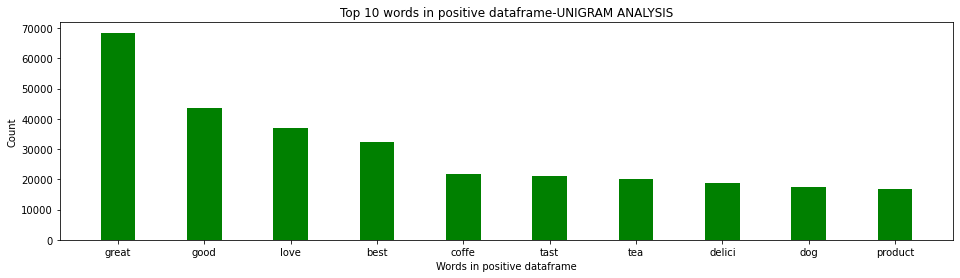

In [43]:
#Visualize positive unigram in bar chart
plt.figure(1,figsize=(16,4))
plt.bar(pd1,pd2, color ='green',
        width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")
plt.show()

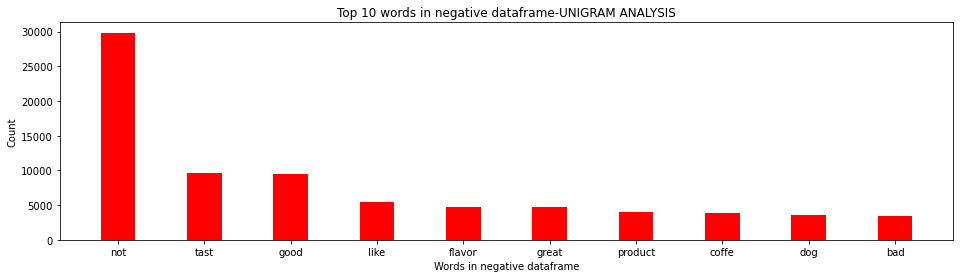

In [44]:
#Visualize negative unigram in bar chart
plt.figure(1,figsize=(16,4))
plt.bar(ned1,ned2, color ='red',
        width = 0.4)
plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in negative dataframe-UNIGRAM ANALYSIS")
plt.show()

**Bigram and Corresponding Visualization**

In [45]:
positiveValues2=defaultdict(int)
negativeValues2=defaultdict(int)

#get count of every bigram in summary for positive feedback
for text in df_ngram[df_ngram.Sentiment=="positive"].ngram_summary:
    for word in generate_n_grams(text, 2):
        positiveValues2[word]+=1
    
#get count of every bigram in summary for negative feedback
for text in df_ngram[df_ngram.Sentiment=="negative"].ngram_summary:
    for word in generate_n_grams(text, 2):
        negativeValues2[word]+=1

In [46]:
#focus on more frequently occuring words for every sentiment
df_positive2=pd.DataFrame(sorted(positiveValues2.items(),key=lambda x:x[1],reverse=True))
df_negative2=pd.DataFrame(sorted(negativeValues2.items(),key=lambda x:x[1],reverse=True))

pd1bi=df_positive2[0][:10]
pd2bi=df_positive2[1][:10]

ned1bi=df_negative2[0][:10]
ned2bi=df_negative2[1][:10]

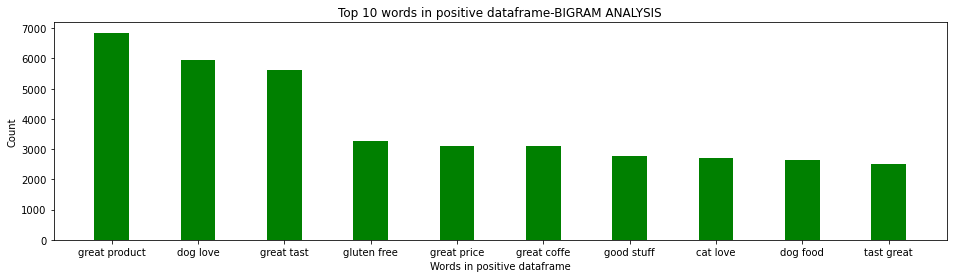

In [47]:
#visualize positive bigrams in bar chart
plt.figure(1,figsize=(16,4))
plt.bar(pd1bi,pd2bi, color ='green',width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-BIGRAM ANALYSIS")
plt.show()

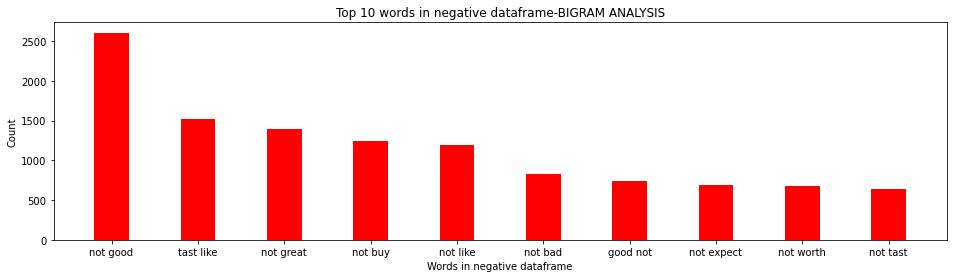

In [48]:
#visualize negative bigrams in bar chart
plt.figure(1,figsize=(16,4))
plt.bar(ned1bi,ned2bi, color ='red',
        width = 0.4)
plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in negative dataframe-BIGRAM ANALYSIS")
plt.show()

**TFIDF-W2V**

In [49]:
data = df_ngram.copy()
model = TfidfVectorizer()
model.fit(data['ngram_summary'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [50]:
i=0
list_of_sentance=[]
for sentance in data['ngram_summary']:
    list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4) #only considered words that occured at least 5 times
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('excel', 0.8679673671722412), ('awesom', 0.8080672025680542), ('fantast', 0.7916932702064514), ('good', 0.7889641523361206), ('terrif', 0.7728770971298218), ('wonder', 0.7636370658874512), ('nice', 0.7528616189956665), ('decent', 0.7459495663642883), ('amaz', 0.7135547399520874), ('fabul', 0.6959536075592041)]
[('greatest', 0.820949912071228), ('best', 0.7611956000328064), ('eaten', 0.7042607069015503), ('tastiest', 0.6670709252357483), ('ive', 0.6299711465835571), ('smoothest', 0.602196216583252), ('drank', 0.5998377799987793), ('yummiest', 0.5507839918136597), ('today', 0.5414446592330933), ('cf', 0.5405799150466919)]


In [51]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:20])

number of words that occured minimum 5 times  8547
sample words  ['good', 'qualiti', 'dog', 'food', 'not', 'advertis', 'delight', 'say', 'cough', 'medicin', 'great', 'taffi', 'nice', 'expens', 'brand', 'wonder', 'tasti', 'yay', 'barley', 'healthi']


In [52]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a summary
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████| 568454/568454 [05:23<00:00, 1757.98it/s]


In [53]:
tfidf_sent_vectors[0]

array([ 0.29782646, -0.05731532,  0.16898845, -0.22528748,  0.79667108,
        0.83153194,  0.25612636,  1.19038756, -1.27465187,  0.29760604,
        1.07162292, -0.42749962,  0.19008138, -1.22573051, -0.00312221,
        1.35993924,  0.27343457,  0.59468377, -0.32425769, -0.46351805,
        0.73195799,  0.7407814 , -0.0564132 ,  0.77521169, -0.06222508,
       -0.29092554,  0.08371999,  0.03329087,  0.1431078 , -0.93819437,
       -0.1722075 ,  0.02896081, -1.17035436,  1.3944476 ,  0.76954439,
       -0.73902115,  1.00374267,  0.83198903, -0.50728368, -1.46448697,
        0.92990149, -1.19029219, -0.95369741,  0.45176368, -0.55038408,
       -0.4034842 ,  0.63157877,  0.06048712,  0.41101973, -0.3479437 ])

## Part III: Model
#### Random Forests, Evaluations, Feature Importance

In [54]:
#Because of some format errors, I am going to reconstruct the text analysis of summary
final_summary = []
for sentance in tqdm(df['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    final_summary.append(sentance.strip())

100%|████████████████████████████████| 568454/568454 [00:08<00:00, 70024.35it/s]


In [55]:
final_summary[1500]

'buy elsewhere'

In [56]:
#get into tfidf and then splitting final_summary into train and test data
#Since we have a lot of features I would choose to apply random forest classification (since Score is discrete)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

In [57]:
#Since my computer is not in good quality, I plan to only use first 50000 data, sorry for the inconvenience
x = final_summary[:50000]
y = np.array(df['Score'])[:50000]
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size = 0.8,test_size = 0.2,random_state = 0)

In [58]:
#tfidf
vectorizer = TfidfVectorizer(min_df = 5) #for words that appear at least 5 times
vectorizer.fit(x_train)
x_train_tf = vectorizer.transform(x_train)
x_train_tf = x_train_tf.toarray()
x_train_tf.shape

(40000, 2462)

In [59]:
x_test_tf = vectorizer.transform(x_test)
x_test_tf = x_test_tf.toarray()
x_test_tf.shape #to check whether train and test have same shape

(10000, 2462)

In [60]:
#I have used the following code to test the max_feature and max_depth, but I commented them out since it takes my
#computer too long to run them again (I ran this in other file to avoid kernel explosion situation)
#n_estimators = 120
#max_features = [50, 100, 150]
#max_depths = [None, 100, 150]
#for f, d in product(max_features, max_depths):
#    rf = RandomForestClassifier(n_estimators = n_estimators,
#                                criterion = 'entropy',
#                                max_features = f,
#                                max_depth = d,
#                                n_jobs = 2,
#                                random_state = 1337
#                               )
#    rf.fit(x_train_tf, y_train)
#    prediction_test = rf.predict(X=x_test_tf)
#    print(f, d, rf.score(x_test_tf, y_test))
#the result is when feature to be around 50, depth to leaf, and have 120 trees give best accuracy of around 0.69
rf=RandomForestClassifier(max_features='sqrt',max_depth=None,n_estimators=120)
rf.fit(x_train_tf,y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=120)

**Evaluations**

In [61]:
#Accuracy
print("Training Accuracy is: ", rf.score(x_train_tf, y_train))
print("Testing Accuracy is: ", rf.score(x_test_tf, y_test))

Training Accuracy is:  0.90445
Testing Accuracy is:  0.6953


In [62]:
#ROC
predi=rf.predict_proba(x_test_tf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi, pos_label=2)
pred=rf.predict_proba(x_train_tf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred, pos_label = 2)

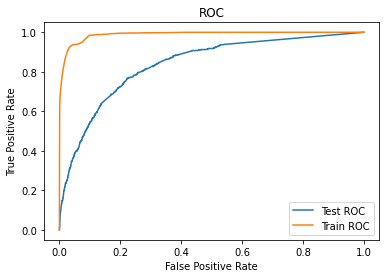

In [63]:
#Visualization
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC')
ax.plot(fpr2, tpr2, label='Train ROC')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

**Feature Importance**

In [64]:
all_features = vectorizer.get_feature_names()
data=''
feat=rf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:20]: #Top 20 important features
The distribution of predictions has changed from those observed during training. 
The training data and the live data have begun to diverge and the training data is no longer a good representation of the real world.
    data+=all_features[i]
    data+=' '

In [65]:
data

'not great good best ok love bad taste delicious coffee okay product like awful pretty horrible excellent tea price flavor '

In [66]:
wordcloud = WordCloud(background_color="white").generate(data)

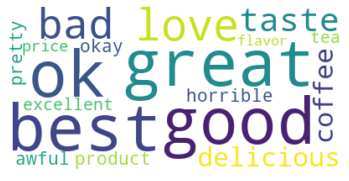

In [68]:
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Restore Model**<br>
<br>
I believe that we do not need to retrain our model every time when add new features or add new observations, we could still use our model to train new dataset. We would consider to retrain our model when the model's performance metrics have deteriorated, or when the training data and the live data have begun to diverge when the training data is no longer a good representation of the real world.